<a href="https://colab.research.google.com/github/romulokps/testesPCR/blob/main/PCRcidades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

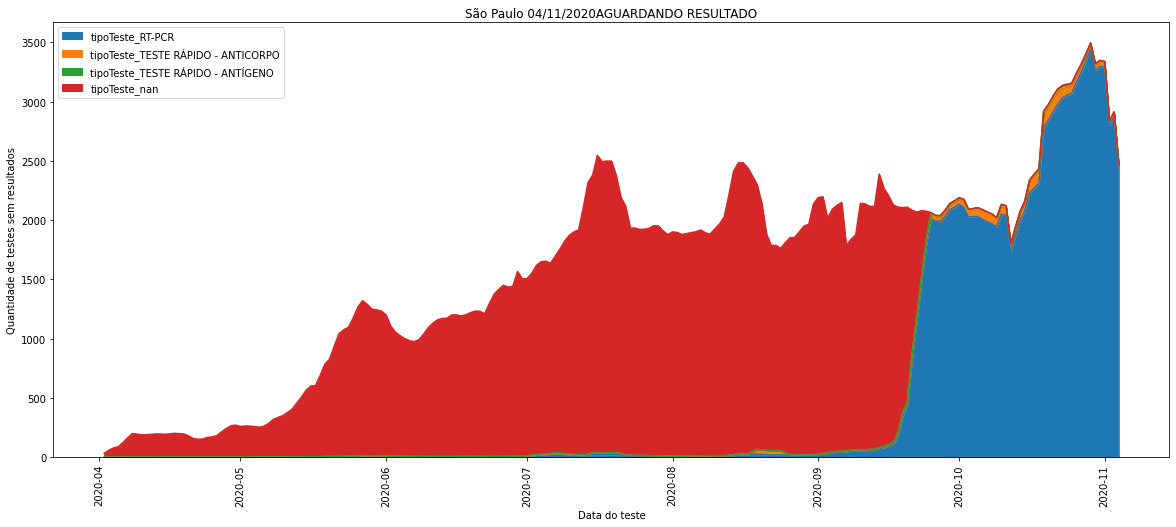

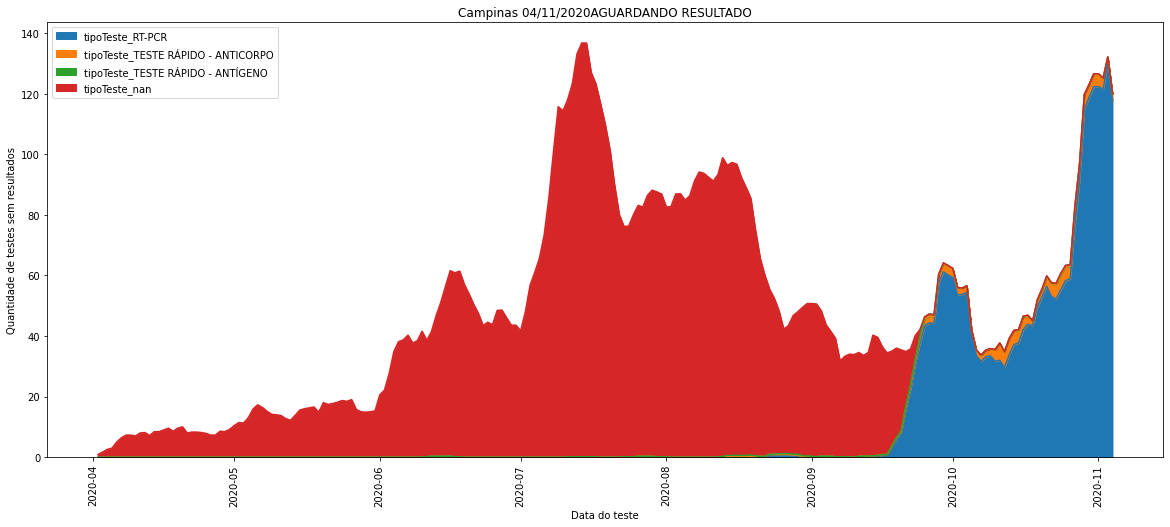

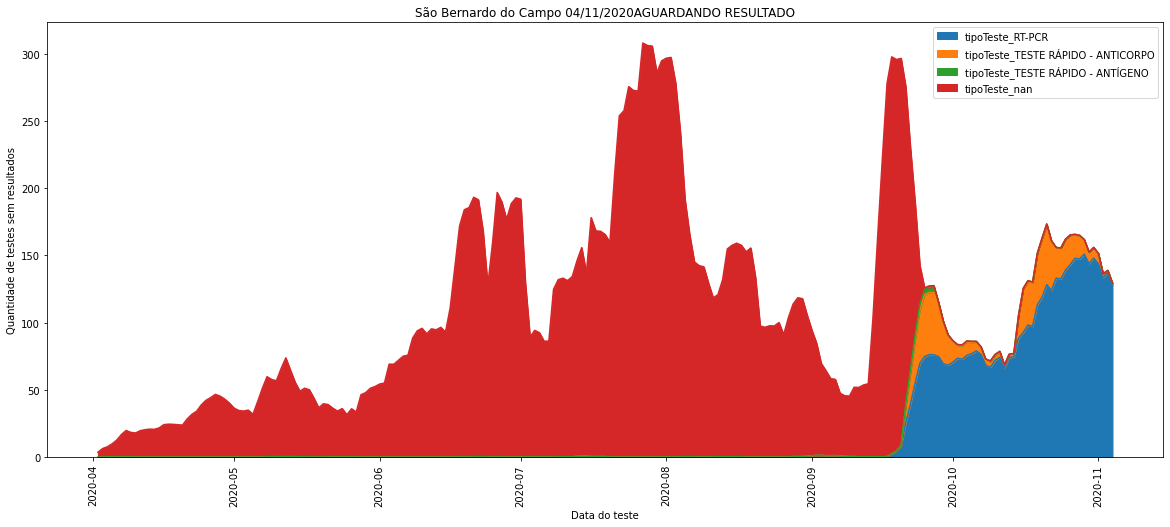

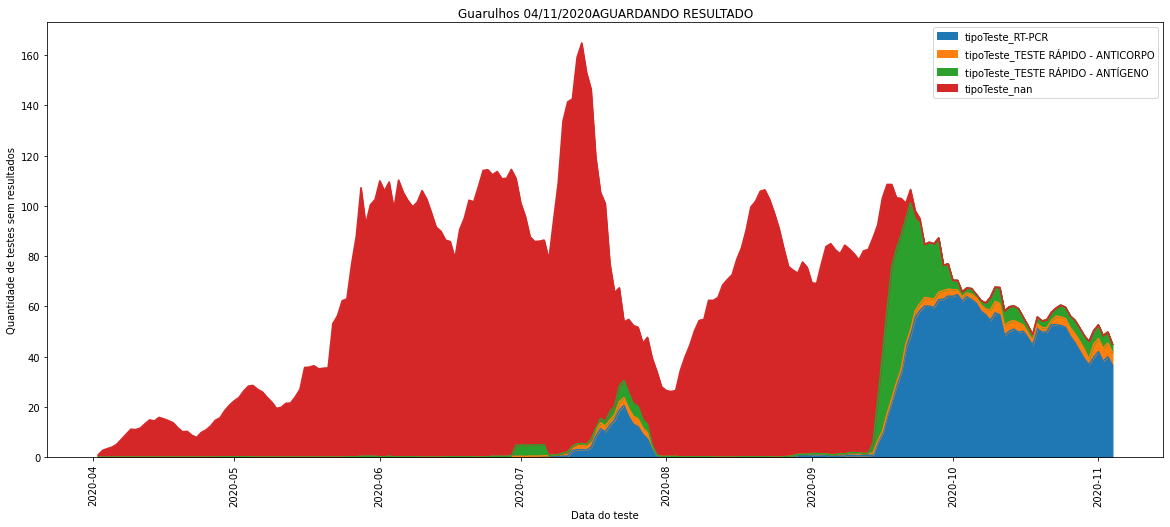

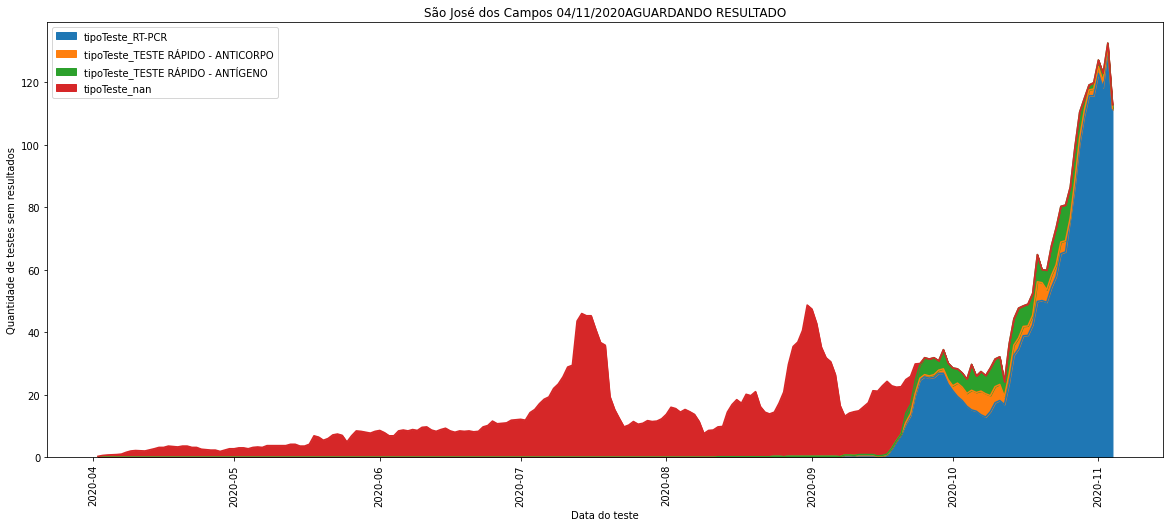

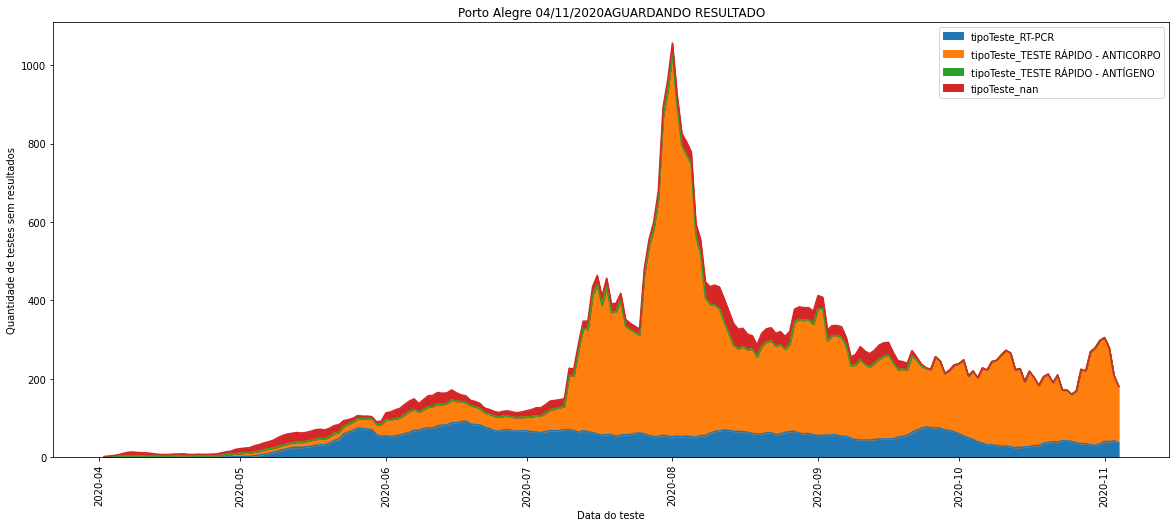

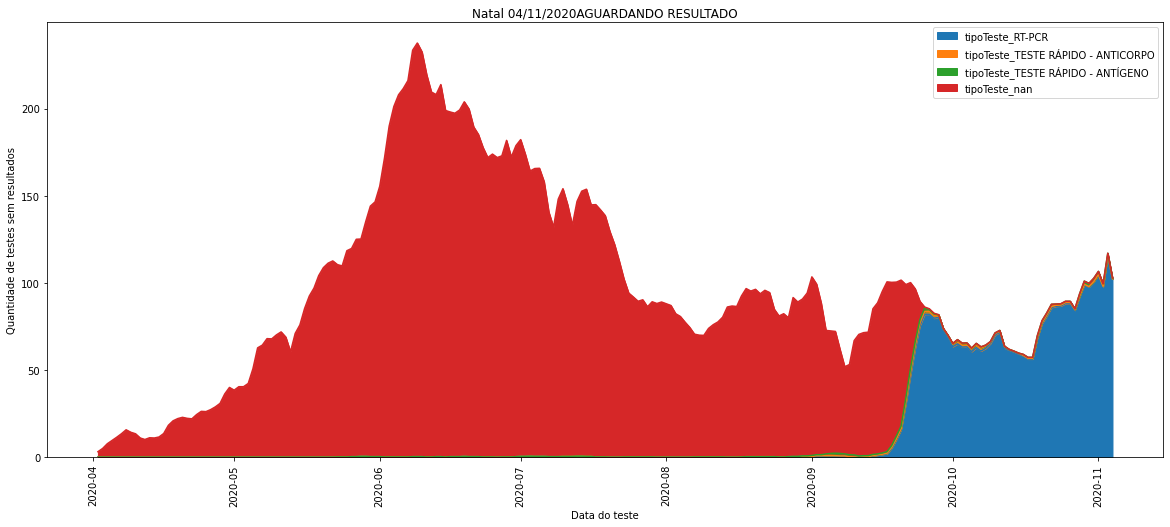

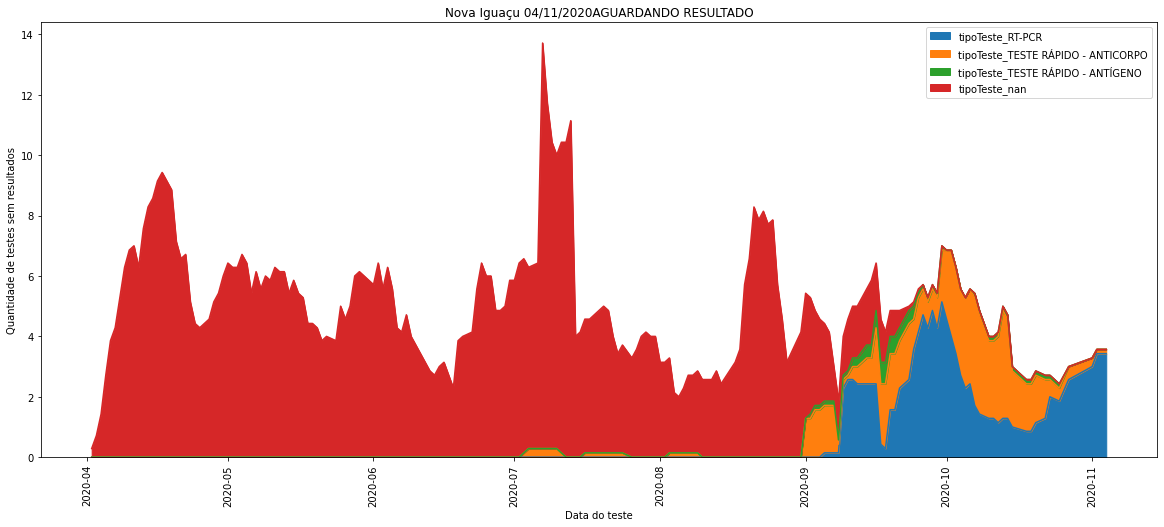

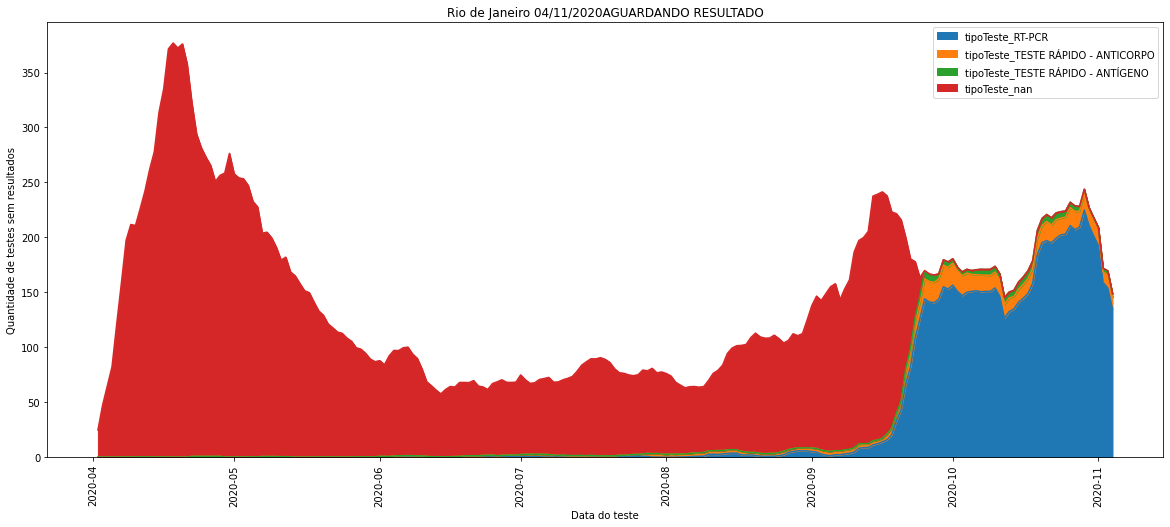

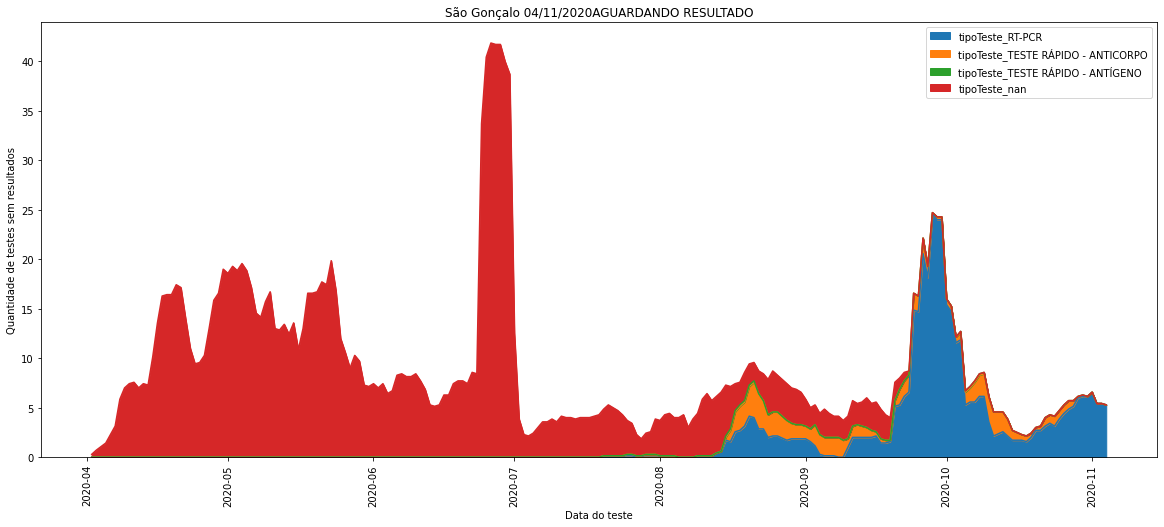

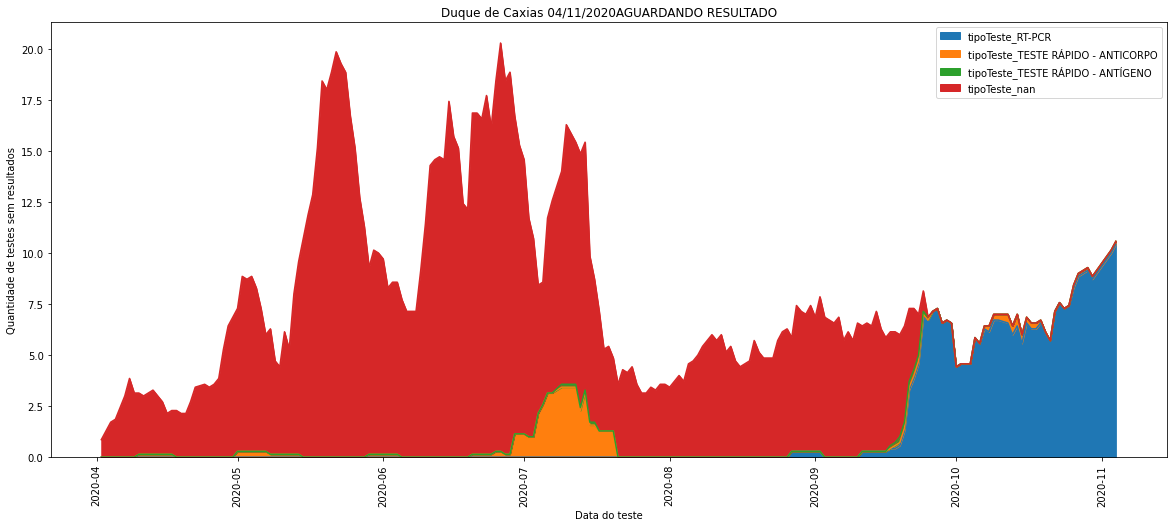

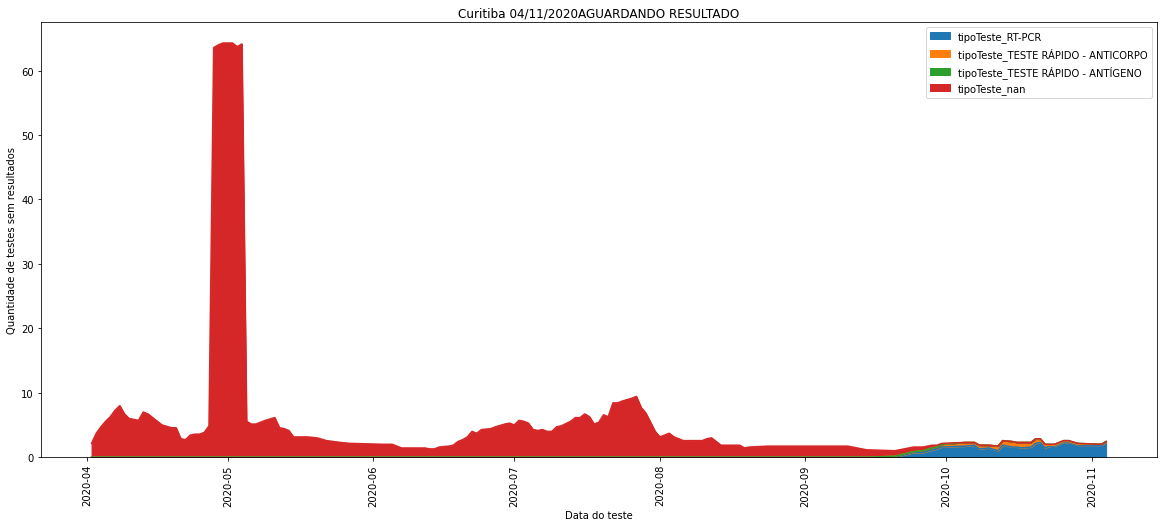

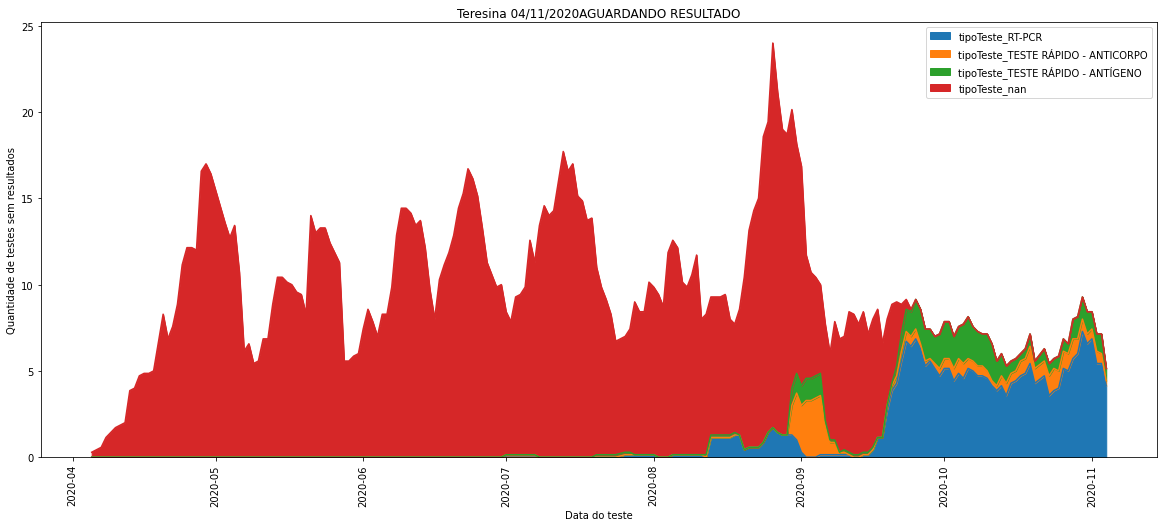

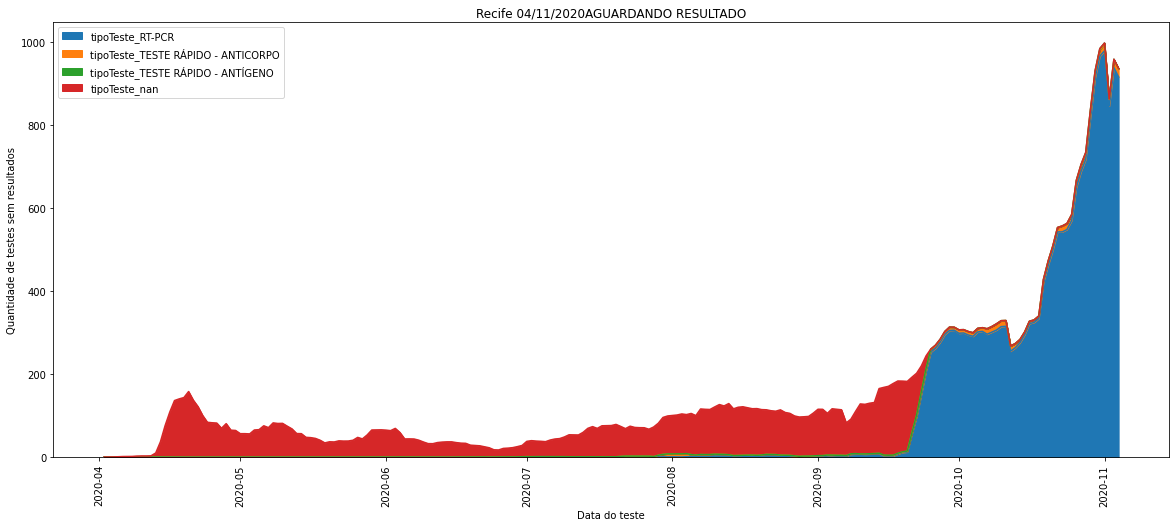

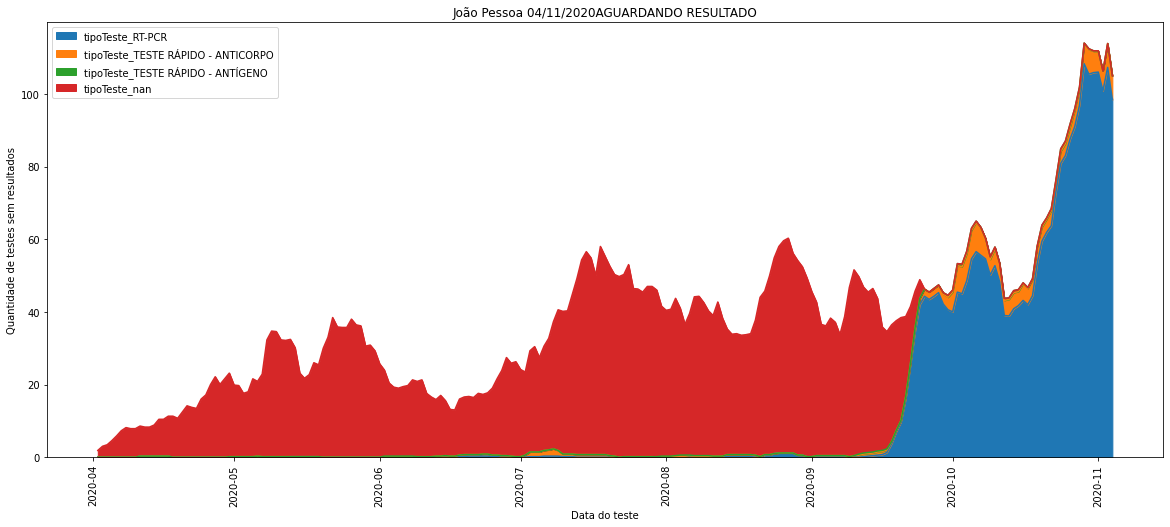

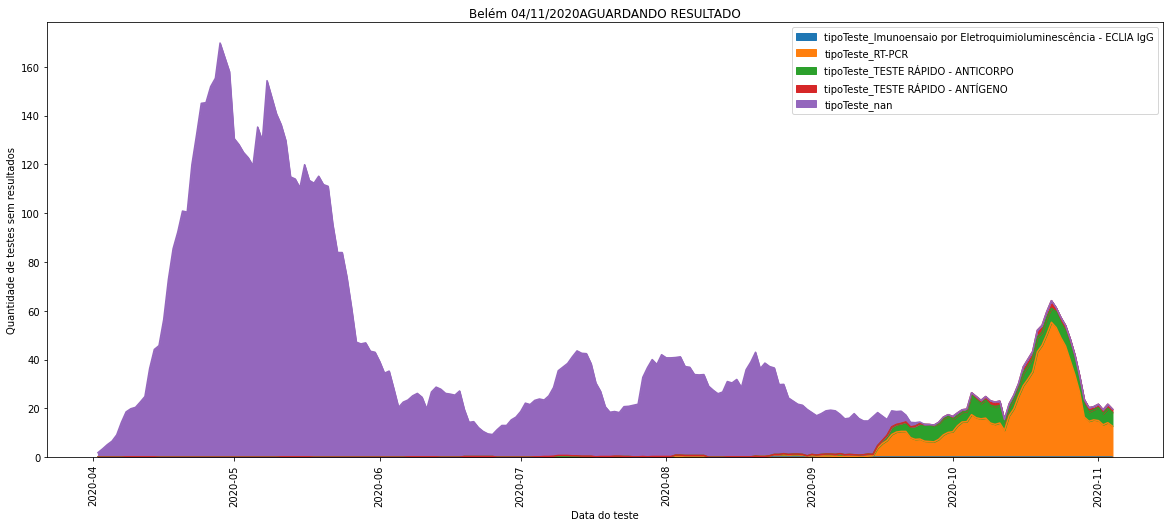

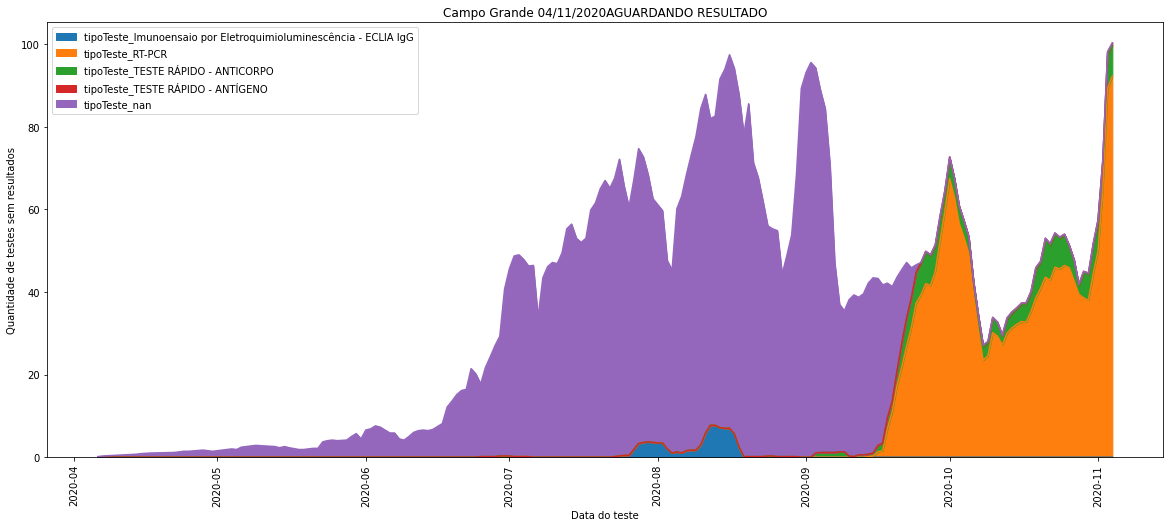

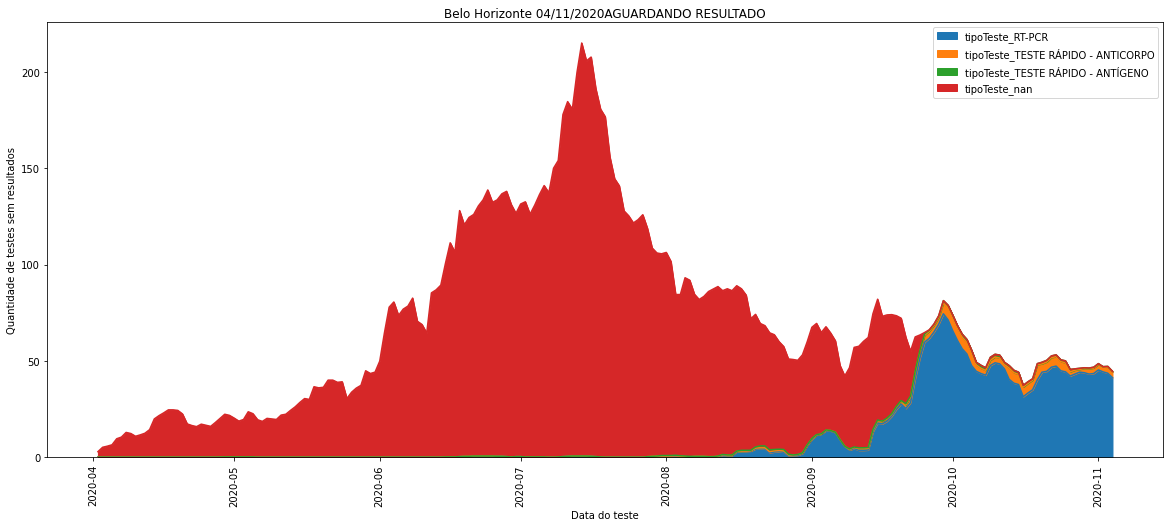

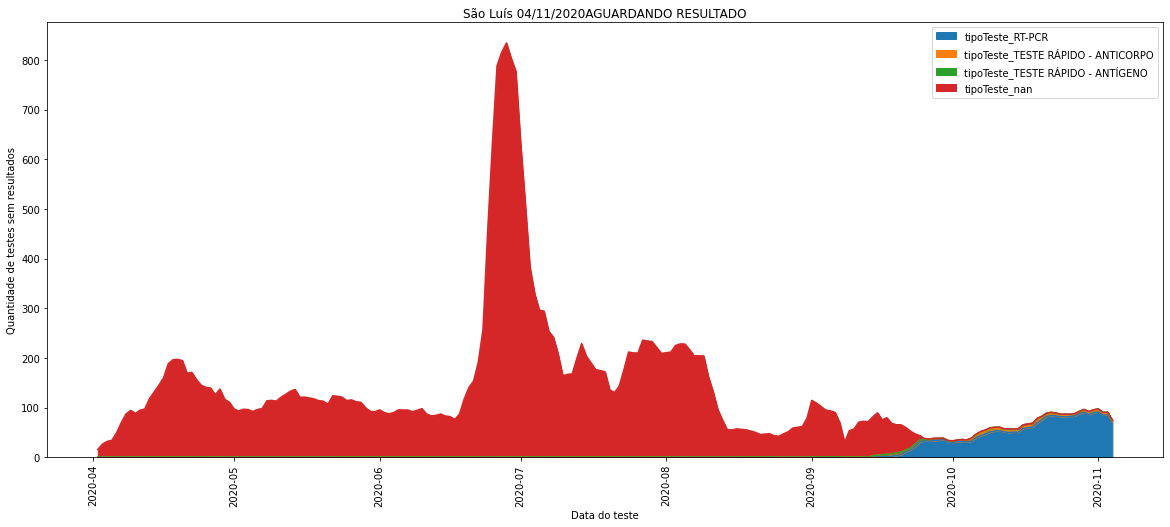

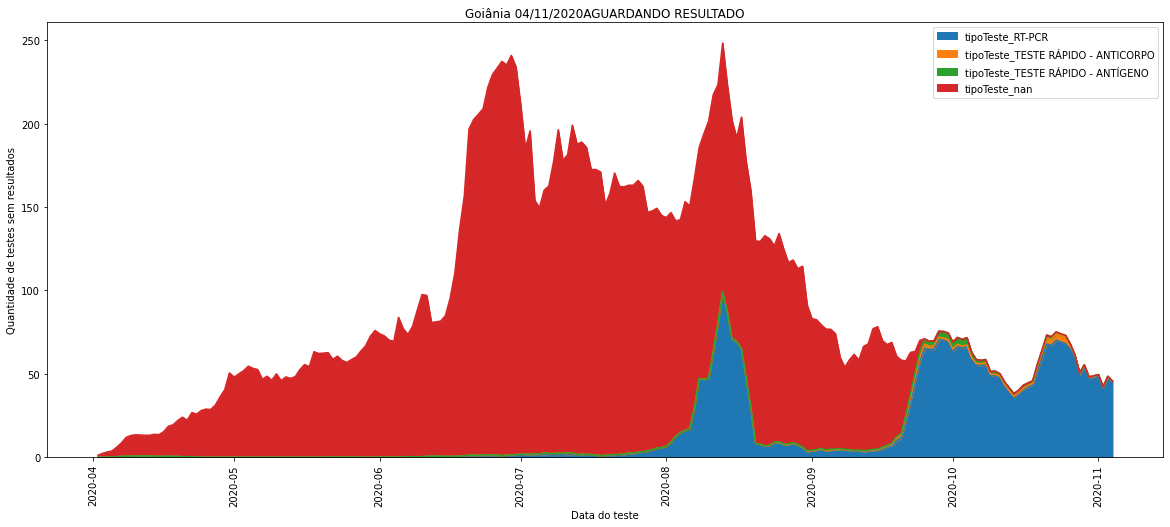

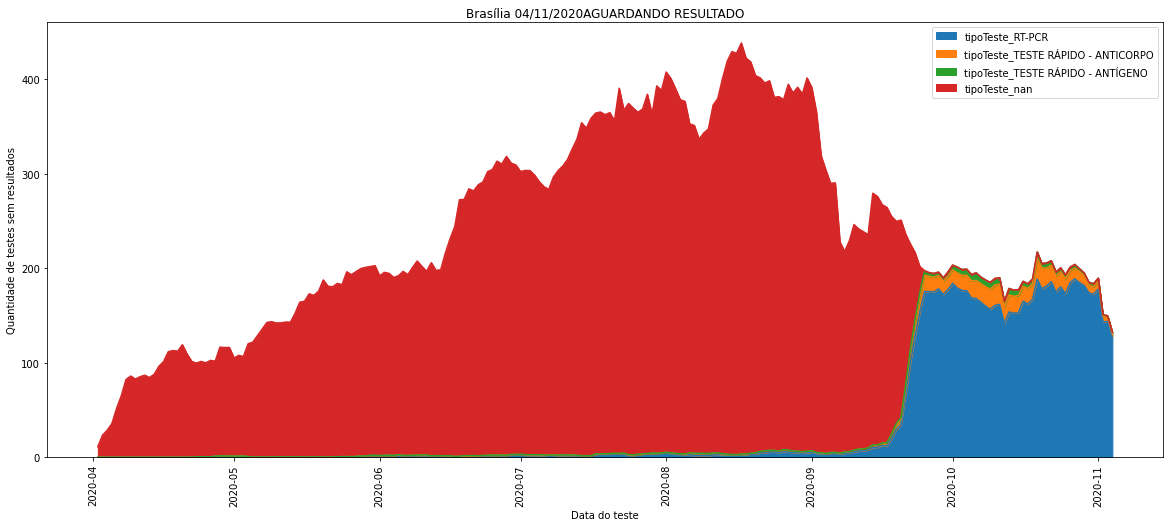

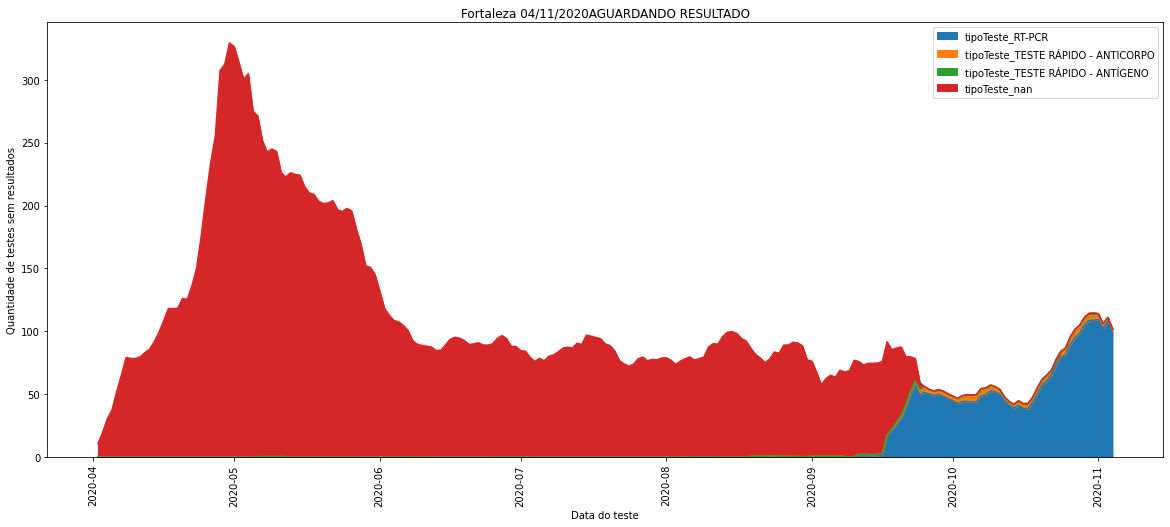

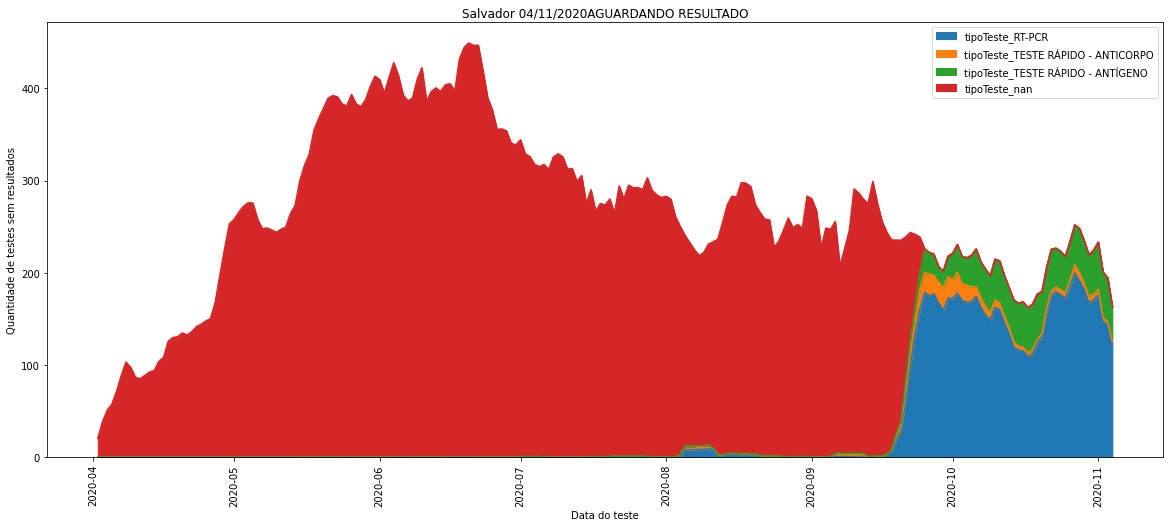

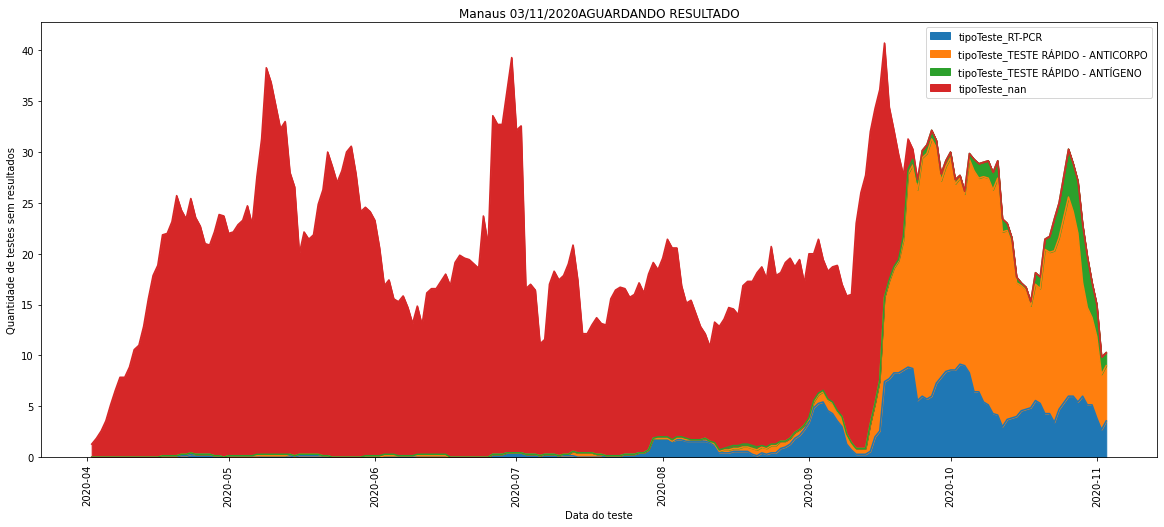

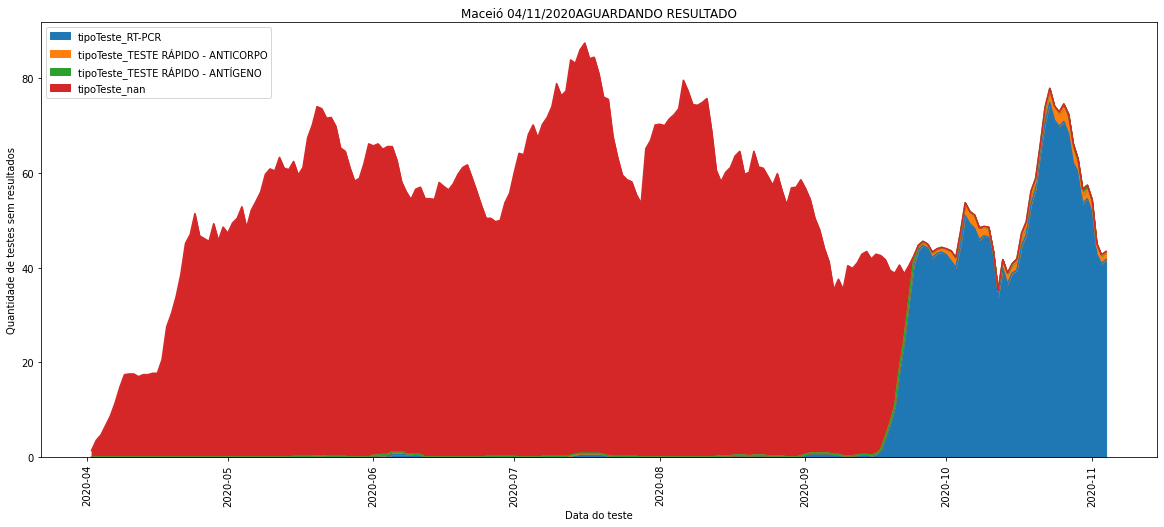

In [21]:
import pandas as pd
import csv
from datetime import datetime
from scipy import stats
import numpy as np
 
caminho = '/content/drive/My Drive/dados/estados 2020-11-07/'
caminho = '/content/drive/My Drive/dados/estados 2020-11-13/'
caminho = '/content/drive/My Drive/dados/estados 2020-10-21/'
caminho = '/content/drive/My Drive/dados/estados 2020-11-23/'
pop = pd.read_csv('https://raw.githubusercontent.com/romulokps/testesPCR/main/populacaoBR.csv')
pop = pop.sort_values(by = 'pop', ascending=False).head(25)
#pop = pop.sort_values(by = 'pop', ascending=False).tail(2)
#pop = pop.sort_values(by = 'pop', ascending=False).head(1)
pop = pop.sort_values(by = 'estado', ascending=False)
#pop = pop.tail(20)
#pop = pop.sort_values(by = 'pop', ascending=False).head(6)
pop = pop.reset_index()
for i in pop.index:
    if ((pop.iloc[i]['estado'] != pop.iloc[i-1]['estado']) ):
     df = pd.read_csv(caminho + pop.iloc[i]['estado'], low_memory = False)
     #df = pd.read_csv(caminho + pop.iloc[i]['estado'], low_memory = False, encoding="latin-1", sep=";", error_bad_lines=False)
    fe = df  
    #fe = fe[fe['tipoTeste'] == 'RT-PCR']
    fe = fe[fe['resultadoTeste'].isnull()]  
    #if (ibge != 0):
    fe = fe[fe['municipioNotificacaoIBGE'] == pop.iloc[i]['ibgeID']]
    #fe = fe[fe['municipioNotificacaoIBGE'] == str(pop.iloc[i]['ibgeID'])] # TIRAR ESSA LINHA SE FOR DADOS DO ES
    estado = pop.iloc[i]['cidade']
    #else:
      #estado = pop.iloc[i]['estadoNome']
    #fe = fe[fe['resultadoTeste'].notnull()]
    fe = fe[fe['resultadoTeste'] != 'Inconclusivo ou Indeterminado']
    fe = fe[['dataTeste', 'tipoTeste','estado']]
    #fe = fe[['dataTeste', 'resultadoTeste','estado']]
    fe['dataTeste'] = pd.to_datetime(fe['dataTeste']).dt.date
    fe = fe[fe['dataTeste'] > datetime.strptime('2020-04-01', '%Y-%m-%d').date()]
    #fe = fe.sort_values(by= ['dataTeste'], ascending=False)
    fe = fe.replace(np.nan, "nan")
    fe = pd.get_dummies(fe, columns=['tipoTeste'])
    fe = fe.groupby('dataTeste').sum()
 
    #tira os outliers
    z_scores = stats.zscore(fe)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 13).all(axis=1)
    fe = fe[filtered_entries]
 
    #total = (fe['resultadoTeste_Positivo'] + fe['resultadoTeste_Negativo'] +  fe['resultadoTeste_nan'] + fe['resultadoTeste_Inconclusivo ou Indeterminado']) 
    #taxa = (fe['resultadoTeste_Positivo']/total).rolling(min_periods=1, window=janela).sum()/janela
    #taxai = (fe['resultadoTeste_Positivo']/(total - fe['resultadoTeste_nan'])).rolling(min_periods=1, window=janela).sum()/janela
    janela = 7
    if (i == 0):
      total = fe
    else:
      total = total + fe
    for i in range(len(fe.columns)):
      fe[fe.columns[i]] = fe[fe.columns[i]].rolling(min_periods=1, window=janela).sum()/janela
    #e['resultadoTeste_Positivo'] = fe['resultadoTeste_Positivo'].rolling(min_periods=1, window=janela).sum()/janela
    #fe['resultadoTeste_Negativo'] = fe['resultadoTeste_Negativo'].rolling(min_periods=1, window=janela).sum()/janela
    #fe['resultadoTeste_Inconclusivo ou Indeterminado'] = fe['resultadoTeste_Inconclusivo ou Indeterminado'].rolling(min_periods=1, window=janela).sum()/janela
    #fe['resultadoTeste_nan'] = fe['resultadoTeste_nan'].rolling(min_periods=1, window=janela).sum()/janela
    #fe.columns = ['Negativo','Positivo','Aguardando?']
    pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
    #ax = fe.plot.area(rot=90, figsize = (20,8), color = ["blue","gold", "black","red"])
    ax = fe.plot.area(rot=90, figsize = (20,8))
    ax.set_title(estado + fe.index[-1].strftime(' %d/%m/%Y') + "AGUARDANDO RESULTADO")
    ax.set_xlabel("Data do teste")
    #ax.set_ylabel("Quantidade de RT-PCR")
    ax.set_ylabel("Quantidade de testes sem resultados")
    ax.figure.savefig(caminho + "img/"+ estado + '.png')
    
    #taxai.plot(rot=90, secondary_y=True)

In [19]:
fe[fe['resultadoTeste'].isnull()]


,Unnamed: 0,Unnamed: 0.1,source_id,municipio,estado,municipioNotificacao,estadoNotificacao,sexo,idade,dataTeste,tipoTeste,classificacaoFinal,resultadoTeste,sintomas,profissionalSaude,profissionalSeguranca,cbo,dataNotificacao,outrosSintomas,estrangeiro,racaCor,evolucaoCaso,estadoTeste,condicoes,dataEncerramento,dataInicioSintomas,_updated_at,@timestamp,estadoIBGE,estadoNotificacaoIBGE,municipioIBGE,municipioNotificacaoIBGE
0,0,0,CvvWXH0S6v,Guarulhos,SÃO PAULO,Guarulhos,SÃO PAULO,Masculino,41,2020-05-26T03:00:00.000Z,NaN,Descartado,NaN,Outros,Não,Não,NaN,2020-06-13T03:00:00.000Z,sem,NaN,Branca,Cura,Coletado,NaN,2020-06-30T03:00:00.000Z,2020-05-26T03:00:00.000Z,2020-06-30T16:54:35.335Z,2020-08-21T13:07:14.319Z,35.0,35.0,3518800.0,3518800.0
2,2,2,qiYoL3st2F,São Paulo,SÃO PAULO,São Paulo,SÃO PAULO,Masculino,36,NaN,NaN,NaN,NaN,Outros,Não,Não,NaN,2020-05-21T03:00:00.000Z,DOR NO CORPO,Não,Parda,Ignorado,NaN,NaN,2020-06-30T03:00:00.000Z,2020-05-12T03:00:00.000Z,2020-06-30T16:54:39.941Z,2020-08-21T13:07:14.319Z,35.0,35.0,3550308.0,3550308.0
7,7,7,fdKJEqBQJl,Vinhedo,SÃO PAULO,Vinhedo,SÃO PAULO,Masculino,19,NaN,NaN,NaN,NaN,"Febre, Outros",Não,Não,NaN,2020-06-16T03:00:00.000Z,"CEFALEIA, VERTIGEM",Não,Amarela,NaN,Exame Não Solicitado,NaN,NaN,2020-06-16T03:00:00.000Z,2020-06-30T16:54:45.552Z,2020-08-21T13:07:14.319Z,35.0,35.0,3556701.0,3556701.0
9,9,9,s9rlgE9dDD,Birigui,SÃO PAULO,Birigui,SÃO PAULO,Masculino,20,NaN,NaN,Descartado,NaN,"Febre, Dor de Garganta",Não,Não,NaN,2020-05-29T03:35:47.916Z,NaN,NaN,Parda,Cura,Exame Não Solicitado,NaN,2020-06-30T03:00:00.000Z,2020-05-27T03:00:00.000Z,2020-06-30T16:54:47.558Z,2020-08-21T13:07:14.319Z,35.0,35.0,3506508.0,3506508.0
10,10,10,YDuOFLjakz,São José do Rio Preto,SÃO PAULO,São José do Rio Preto,SÃO PAULO,Feminino,20,NaN,NaN,NaN,NaN,"Tosse, Outros",Não,Não,NaN,2020-06-30T16:50:56.223Z,"cefaleia, dor torácica ao respirar",Não,Branca,NaN,Solicitado,NaN,NaN,2020-06-30T03:00:00.000Z,2020-06-30T16:54:47.816Z,2020-08-21T13:07:14.319Z,35.0,35.0,3549805.0,3549805.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254274,1654274,1654274,F39Ofu9Hro,São Paulo,SÃO PAULO,São Paulo,SÃO PAULO,Masculino,29,2020-11-04T03:00:00.000Z,RT-PCR,NaN,NaN,"Dor de Cabeça, Distúrbios Gustativos, Distúrbi...",Não,Não,NaN,2020-11-04T03:00:14.461Z,NaN,NaN,Parda,NaN,Coletado,NaN,NaN,2020-11-01T03:00:00.000Z,2020-11-04T18:37:19.828Z,2020-11-05T00:50:03.650Z,35.0,35.0,3550308.0,3550308.0
5254275,1654275,1654275,RuJoEcEcgo,Colômbia,SÃO PAULO,Colômbia,SÃO PAULO,Feminino,7,NaN,RT-PCR,NaN,NaN,"Febre, Dor de Garganta, Dor de Cabeça",Não,Não,NaN,2020-11-02T03:00:00.000Z,NaN,Não,Parda,NaN,Solicitado,NaN,NaN,2020-11-02T03:00:00.000Z,2020-11-04T18:37:21.770Z,2020-11-05T00:50:03.650Z,35.0,35.0,3512100.0,3512100.0
5254276,1654276,1654276,bzh5pX8S1j,Guarulhos,SÃO PAULO,Guarulhos,SÃO PAULO,Masculino,70,2020-08-29T03:00:00.000Z,RT-PCR,NaN,NaN,"Tosse, Outros",Não,Não,NaN,2020-08-29T03:00:00.000Z,DOR ABDOMINAL,NaN,Amarela,NaN,Coletado,Doenças renais crônicas em estágio avançado (g...,NaN,2020-08-23T03:00:00.000Z,2020-11-04T18:37:21.859Z,2020-11-05T00:50:03.650Z,35.0,35.0,3518800.0,3518800.0
5254277,1654277,1654277,UnHjpUlh8D,São Paulo,SÃO PAULO,São Paulo,SÃO PAULO,Masculino,33,2020-11-04T03:00:00.000Z,RT-PCR,NaN,NaN,"Outros, Febre",Não,Não,NaN,2020-11-04T03:00:34.099Z,diarréia,NaN,Branca,NaN,Coletado,NaN,NaN,2020-11-01T03:00:00.000Z,2020-11-04T18:37:22.208Z,2020-11-05T00:50:03.650Z,35.0,35.0,3550308.0,3550308.0


In [18]:
fe['resultadoTeste'].value_counts(dropna = False)

Negativo                         2682027
NaN                              1398624
Positivo                         1170860
Inconclusivo ou Indeterminado       2768
Name: resultadoTeste, dtype: int64